In [55]:
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import joblib
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
# Load LSI vectors and speech IDs
with open("pkl_files/lsi_vectors.pkl", "rb") as f:
    lsi_vectors = pickle.load(f)

with open("pkl_files/speech_ids.pkl", "rb") as f:
    speech_ids = pickle.load(f)

# Normalize LSI vectors
lsi_vectors_normalized = normalize(lsi_vectors)

# Define the range for number of clusters
cluster_range = range(10, 250, 10)  # From 10 to 100 clusters

# Initialize lists to store evaluation metrics
wcss = []
silhouette_scores = []

In [57]:
# Determine optimal number of clusters using Elbow Method and Silhouette Analysis
for k in cluster_range:
    mbk = MiniBatchKMeans(n_clusters=k, batch_size=1000, max_iter=100, random_state=42)
    mbk.fit(lsi_vectors_normalized)
    wcss.append(mbk.inertia_)
    
    # Compute silhouette score on a sample
    sample_size = 30000
    sil_score = silhouette_score(lsi_vectors_normalized, mbk.labels_, metric='cosine', sample_size=sample_size, random_state=42)
    silhouette_scores.append(sil_score)
    
    print(f"Processed k={k}, WCSS={mbk.inertia_:.2f}, Silhouette Score={sil_score:.4f}")

Processed k=10, WCSS=22572.18, Silhouette Score=0.2601
Processed k=20, WCSS=16310.80, Silhouette Score=0.2560
Processed k=30, WCSS=14443.47, Silhouette Score=0.1924
Processed k=40, WCSS=12815.45, Silhouette Score=0.2006
Processed k=50, WCSS=11789.96, Silhouette Score=0.2006
Processed k=60, WCSS=11034.95, Silhouette Score=0.1856
Processed k=70, WCSS=10502.12, Silhouette Score=0.1837
Processed k=80, WCSS=10067.31, Silhouette Score=0.1802
Processed k=90, WCSS=9702.84, Silhouette Score=0.1799
Processed k=100, WCSS=9351.22, Silhouette Score=0.1728
Processed k=110, WCSS=9077.16, Silhouette Score=0.1751
Processed k=120, WCSS=8805.22, Silhouette Score=0.1694
Processed k=130, WCSS=8620.29, Silhouette Score=0.1671
Processed k=140, WCSS=8422.84, Silhouette Score=0.1690
Processed k=150, WCSS=8258.31, Silhouette Score=0.1635
Processed k=160, WCSS=8145.95, Silhouette Score=0.1658
Processed k=170, WCSS=7978.02, Silhouette Score=0.1597
Processed k=180, WCSS=7863.58, Silhouette Score=0.1588
Processed k

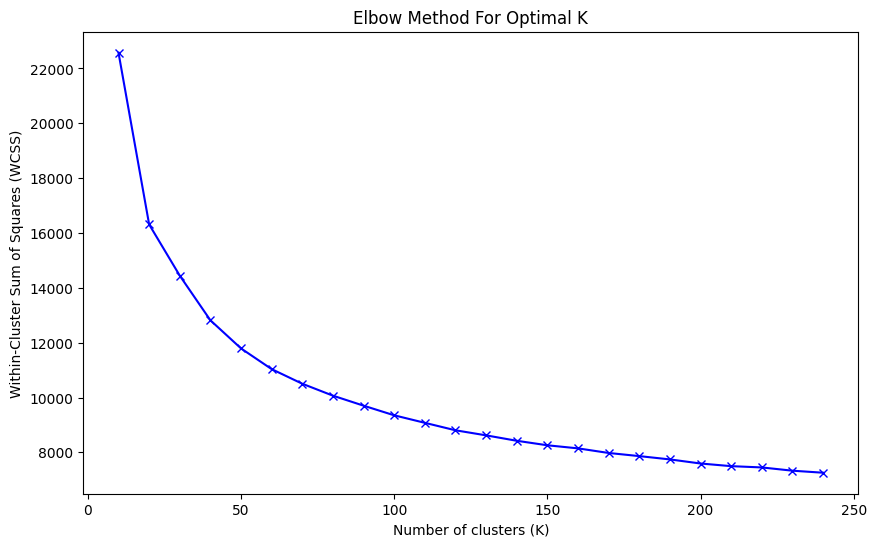

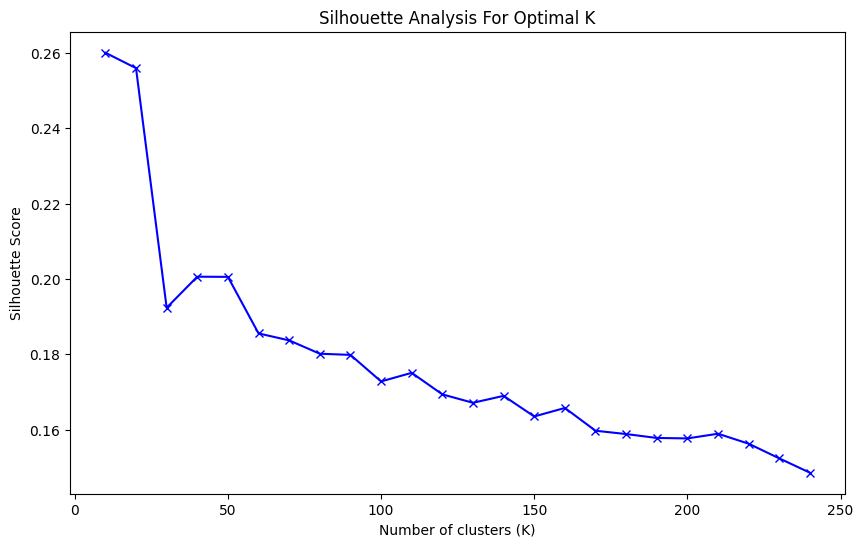

In [58]:
# Plot Elbow Method
plt.figure(figsize=(10,6))
plt.plot(cluster_range, wcss, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method For Optimal K')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10,6))
plt.plot(cluster_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal K')
plt.show()

In [53]:
from db import get_db
def connect_to_db():
    engine = get_db()  # Call the `get_db` function to get the engine
    metadata = MetaData()
    merged_speeches = Table("merged_speeches", metadata, autoload_with=engine)  # Use the engine for autoload
    return engine, merged_speeches


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def get_cluster_keywords(speeches, cluster_labels, num_keywords=10):
    """
    Extract top keywords for each cluster.
    
    :param speeches: List of all speeches
    :param cluster_labels: Cluster assignments for each speech
    :param num_keywords: Number of top keywords to extract per cluster
    :return: Dictionary of cluster_id -> top_keywords
    """

    with open("pkl_files/tfidf_matrix.pkl", "rb") as f:
        tfidf_matrix = pickle.load(f)

    with open("pkl_files/speech_ids.pkl", "rb") as f:
        speech_ids = pickle.load(f)

    with open('pkl_files/tfidf_vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)

    feature_names = vectorizer.get_feature_names_out()

    
    cluster_keywords = {}
    for cluster_id in np.unique(cluster_labels):
        # Get speeches belonging to this cluster
        cluster_indices = np.where(cluster_labels == cluster_id)
        cluster_speeches = tfidf_matrix[cluster_indices]
        
        # Compute mean tf-idf score for the cluster
        mean_tfidf = cluster_speeches.mean(axis=0).A1
        top_keywords_indices = mean_tfidf.argsort()[-num_keywords:][::-1]
        top_keywords = [feature_names[i] for i in top_keywords_indices]
        
        cluster_keywords[cluster_id] = top_keywords
    
    return cluster_keywords

# Example Usage:
# speeches = ["list of all speech texts from database"]
# cluster_labels = kmeans.labels_
keywords_per_cluster = get_cluster_keywords(speeches, cluster_labels, num_keywords=10)


NameError: name 'speeches' is not defined